<a href="https://colab.research.google.com/github/himanshu-warulkar/JAX-and-Flax-projects/blob/main/simple_neural_network_from_scratch_using_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lets Build a simple Neural Network from scratch using JAX

In [1]:
!cat /proc/cpuinfo # check processor info

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2200.168
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmio_stale_data retbleed bhi
bogomips	: 4400.33
clflush size	: 64
cache_alignment	: 64
ad

**Resources**

* https://coderzcolumn.com/tutorials/artificial-intelligence/guide-to-create-simple-neural-networks-using-jax
* https://coderzcolumn.com/tutorials/artificial-intelligence/jax-guide-to-create-convolutional-neural-networks

# TPU setup

In [2]:


USE_TPU = False

if USE_TPU:

    import jax
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
else:
    # x8 cpu devices
    import jax
    import os
    os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=2'

batch_size = 202
num_replicas = len(jax.devices())
jax.devices()

[CpuDevice(id=0), CpuDevice(id=1)]

In [3]:
print("JAX Version : {}".format(jax.__version__))

JAX Version : 0.5.2


# Imports

In [4]:

import numpy as np
import jax.numpy as jnp

#just in time compilation
from jax import jit
#for tracing functions
from jax import make_jaxpr

#for auto dif
from jax import grad
from jax import value_and_grad

#vectorization
from jax import vmap

#parallelization (across devices)
from jax import pmap


import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

# Configuration

In [5]:
class CFG:
    TPU = USE_TPU
    jax_seed = jax.random.PRNGKey(7)
    input_features = 13



**Loading Dataset**

     We will use the Boston Housing Dataset for training the model to predict house prices

In [6]:
#load data from kereas dataset
(X_train,Y_train),(X_test,Y_test)=tf.keras.datasets.boston_housing.load_data(path="boston_housing.npz", test_split=0.2, seed=113)



#convert into jax numpy arrays
X_train,X_test,Y_train,Y_test= jnp.array(X_train, dtype=jnp.float32),\
                                   jnp.array(X_test, dtype=jnp.float32),\
                                   jnp.array(Y_train, dtype=jnp.float32),\
                                   jnp.array(Y_test, dtype=jnp.float32)

X_train.shape,X_test.shape

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((404, 13), (102, 13))

# A simple Neural Network

    A simple Dense layer can be expressed mathematically as output = WX + B ; where X is the input , W is the weight matrix and B is bias matrix. This is followed by a non-linear activation like Relu. Hence the output = Relu(WX + B)
    
    We can just repeat this process for adding new dense layers, hence output2 = Relu( W(output1) + B) ; where output1 is output from the first dense layer.
    
    Lets try to do this operation using JAX

In [7]:
def Initialize_W_B(layer_units,
                   seed=CFG.jax_seed
                  ):
    '''initialize weights and biases
    Input:
    layer_units:list of dense layer units '''

    weights_and_bias = []

    for i, units in enumerate(layer_units):

        #first layer weight has dimn (num_units,input shape)
        if i==0:
            w = jax.random.uniform(key=seed, shape=(units, CFG.input_features), minval=-1.0, maxval=1.0, dtype=jnp.float32)


        #if not first kayer
        else:
            w = jax.random.uniform(key=seed, shape=(units, layer_units[i-1]), minval=-1.0, maxval=1.0,
                                   dtype=jnp.float32)

        #bias vector
        b = jax.random.uniform(key=seed, minval=-1.0, maxval=1.0, shape=(units,), dtype=jnp.float32)

        #append weights
        weights_and_bias.append([w,b])

    return weights_and_bias

In [8]:
#lets define our neural network usinng the function defined above

CFG.layer_units = [32,16,1]

Weights_n_B= Initialize_W_B(CFG.layer_units)

for i,layer in enumerate(Weights_n_B):
    print(f'Layer {i}  --->  Weight matrix: {layer[0].shape} || Bias vector : {layer[1].shape}')

Layer 0  --->  Weight matrix: (32, 13) || Bias vector : (32,)
Layer 1  --->  Weight matrix: (16, 32) || Bias vector : (16,)
Layer 2  --->  Weight matrix: (1, 16) || Bias vector : (1,)


# Building a dense Neural layer

In [9]:

# activation_function =

def linear_layer(inp,layer_weights):
    '''performs dot product between weights and a single input.


      if input has m features; and layer has n units ; the output will dot(1*m,m*n) -> 1 * n '''
    W,b = layer_weights

    return (jnp.dot(inp,W.T) + b)


def activated_dense(inp,layer_weights,activation=None):
    lin = linear_layer(inp,layer_weights)


    if activation == None:
        return lin
    elif activation == 'relu':

        return jnp.maximum(jnp.zeros_like(a=lin),lin)

    else:
        return activation(lin)


**Trial run of this Dense layer function**

    all we are doing here is :
    1) linear_layer =  WX + b
    2)  Relu_activation(linear_layer)
    
    This gives us a single Dense layer.

In [10]:
# input = 1* 13 : output : (1*13 @13*32) + 1*32 -> 1*32

activated_dense(inp=X_train[0],
                layer_weights=Weights_n_B[0],
                activation='relu')

Array([  6.95007, 191.62221, 344.90616,   0.     , 167.05762, 714.6283 ,
       339.20795, 326.6767 , 301.65125, 156.95317,  18.5743 ,   0.     ,
         0.     ,   0.     , 333.99103, 102.00512, 541.8057 ,   0.     ,
         0.     ,   0.     , 193.69907, 234.57742, 243.62715, 449.98648,
       265.86432,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
         0.     , 636.3553 ], dtype=float32)

# Putting together the multiple units of NN

In [11]:
# def ForwardPass(input_example,weights):
#     '''forward pass for a single training example'''

#     x = input_example

#     #iterate till the last layer
#     for layer_num in range(len(weights[:-1])):

#         print(layer_num,x.shape)
#         x = activated_dense(inp=x,
#                             layer_weights=weights[layer_num],
#                             activation='relu')

#     output = activated_dense(inp=x,
#                             layer_weights=weights[layer_num],
#                             activation=None)

#     return output

def my_forward_pass(input_example,weights):
    '''simple forward pass of our NN'''

    #first dense
    layer_1_out = activated_dense(inp=input_example,
                                layer_weights=weights[0],
                                activation='relu')


    #secnd dense
    layer_2_out = activated_dense(inp=layer_1_out,
                                layer_weights=weights[1],activation='relu')

    #final out

    final_out = activated_dense(inp=layer_2_out,
                                layer_weights=weights[2],
                                activation=None)


    return final_out

# The Neural Network forward pass

In [13]:
my_forward_pass(input_example=X_train[0],
                weights=Weights_n_B) # Remove np.array conversion

Array([-316.45602], dtype=float32)

**we can also check what is happening with our input using this code**

In [14]:
#we can also check what is happening with our input using this code
trace_my_forward_pass = make_jaxpr(my_forward_pass)

trace_my_forward_pass(X_train[0],Weights_n_B)

{ lambda ; a:f32[13] b:f32[32,13] c:f32[32] d:f32[16,32] e:f32[16] f:f32[1,16] g:f32[1]. let
    h:f32[13,32] = transpose[permutation=(1, 0)] b
    i:f32[32] = dot_general[
      dimension_numbers=(([0], [0]), ([], []))
      preferred_element_type=float32
    ] a h
    j:f32[32] = add i c
    k:f32[32] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(32,)
      sharding=None
    ] 0.0
    l:f32[32] = max k j
    m:f32[32,16] = transpose[permutation=(1, 0)] d
    n:f32[16] = dot_general[
      dimension_numbers=(([0], [0]), ([], []))
      preferred_element_type=float32
    ] l m
    o:f32[16] = add n e
    p:f32[16] = broadcast_in_dim[
      broadcast_dimensions=()
      shape=(16,)
      sharding=None
    ] 0.0
    q:f32[16] = max p o
    r:f32[16,1] = transpose[permutation=(1, 0)] f
    s:f32[1] = dot_general[
      dimension_numbers=(([0], [0]), ([], []))
      preferred_element_type=float32
    ] q r
    t:f32[1] = add s g
  in (t,) }

**This works as expected. We have sucessfully done a forward pass of the Neural network with 32,16,1 layers**

# Parallelizing the forward pass to make use of all the devices on the cluster

    The purpose of parallelizing the operation is to use all the devices on the cluster. So if our TPU cluster has 8 devices, we can send a portion of data to each device for training in parallel and utilize the hardware better.

In [15]:
parallel_my_forward_pass = pmap(my_forward_pass,in_axes = (0,None))


#testing the parallel map

#converting the input data in the format (num_of_devices,batch_size,feature_size)
x_batched = X_train[:batch_size*2].reshape((num_replicas,batch_size,13))


#the output is of the format (num_device,batch_size,output_size)
parallel_my_forward_pass(x_batched,Weights_n_B).shape

(2, 202, 1)

# Defining the loss function; and backpropagating the loss

    The loss for our case (Regression) will be the simple Mean Squared error, which is just the mean of squared error.
    
    After we get the output value and we get the loss , we can backpropagate the loss by finding the derivate of each layer with respect to the loss and thereby improve the model

In [16]:
def MeanSquaredError(input_data, target,weights):
    '''mean squared error loss : ie: mean((y_true - y_pred)^2)'''
    preds = my_forward_pass( input_data,weights)
    return jnp.power(target - preds, 2).mean()



#lets try this out for first 10 values of trainig data
MeanSquaredError(X_train[:10],Y_train[:10],Weights_n_B)

Array(133850.73, dtype=float32)

In [17]:

def CalculateGradients(input_data, target,weights):
    '''calculate the gradients of loss function wrt weights'''
    Gradient_MSE = grad(MeanSquaredError)
    return Gradient_MSE(input_data, target,weights)

#lets try this out for first 2 values of trainig data
CalculateGradients(X_train[:2],Y_train[:2],Weights_n_B)


Array([[-106.15985  , -101.64211  , -288.18997  ,  155.1807   ,
        -134.95576  ,   15.96553  ,  157.59633  , -144.97601  ,
         -92.50748  ,  299.95422  ,  327.91492  ,   14.881355 ,
        -352.4676   ],
       [ -98.57437  ,  -98.84669  , -264.39575  ,  136.28723  ,
        -141.1933   ,   15.087387 ,  159.22345  , -136.5686   ,
         -98.54098  ,  292.0335   ,  328.69403  ,   14.2823105,
        -346.5394   ]], dtype=float32)

In [18]:
def UpdateWeights(learning_rate:float, weights:list, gradients):
    '''update weights for layers of nn'''

    for j in range(len(weights)): ## Update Weights
        weights[j][0] -= learning_rate * gradients[j][0] ## Update Weights
        weights[j][1] -= learning_rate * gradients[j][1] ## Update Biases

In [19]:
def train_step(input_data, target,weights):
    '''single epoch training step'''
    loss = MeanSquaredError(input_data, target,weights) ## Loss of batch
    gradients = CalculateGradients(input_data, target,weights)
    UpdateWeights(learning_rate, weights, gradients) ## Update Weights

    return loss


# Training the Neural Network

In [20]:
print('Mean squared error on test set before training is {:.2f}'.format(MeanSquaredError(X_test,Y_test,Weights_n_B)))

Mean squared error on test set before training is 115986.38


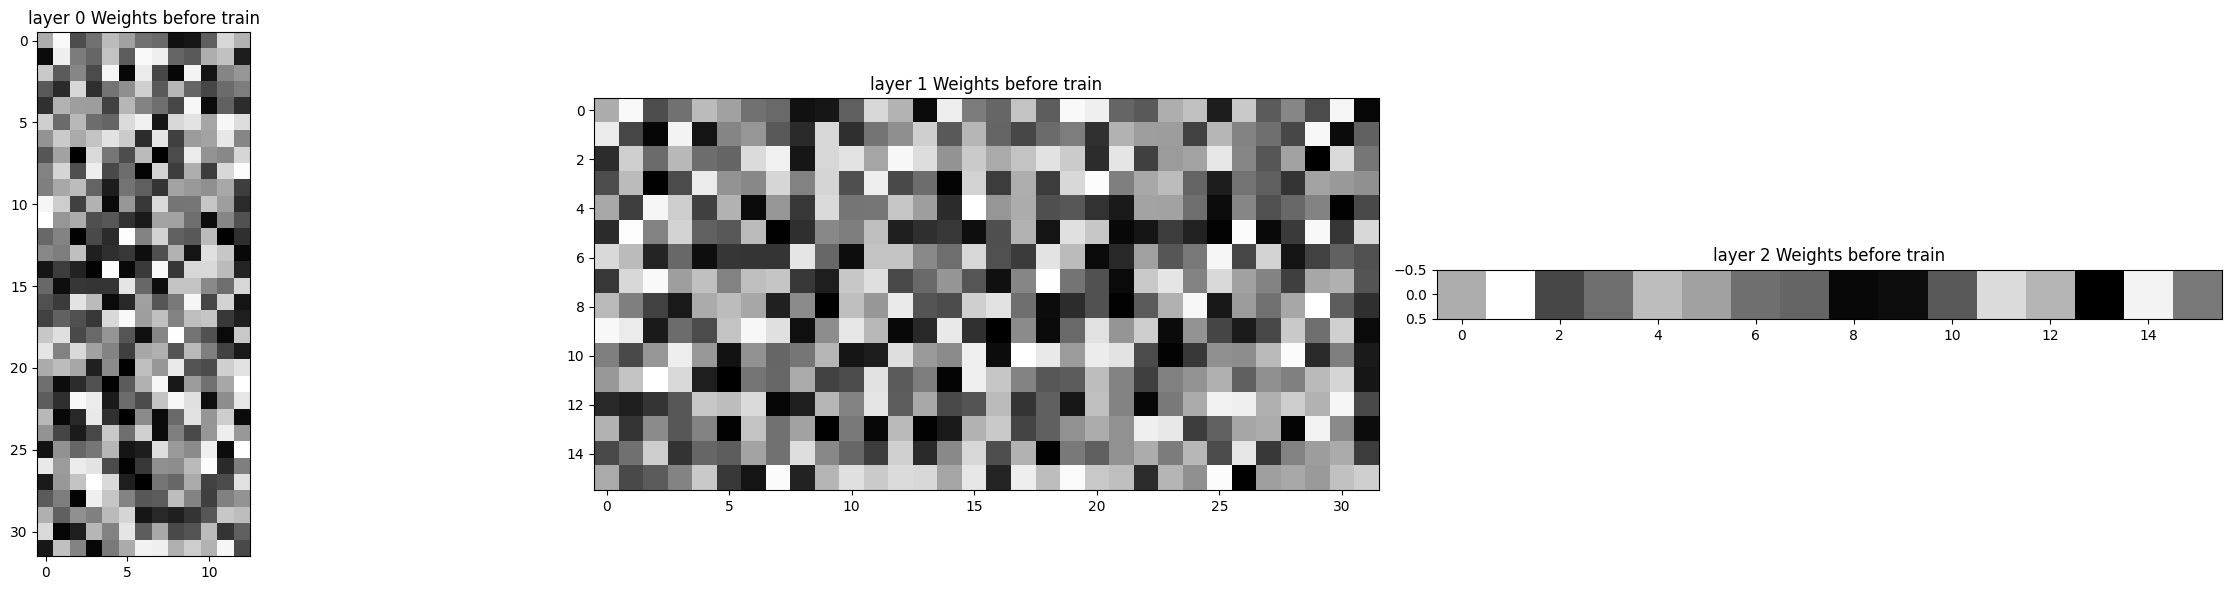

In [21]:
fix,ax = plt.subplots(1,3,figsize=(25,6))
for i,axes in enumerate(ax):
    w = Weights_n_B[i][0]
    axes.imshow(w,cmap='gray')
    axes.set_title(f'layer {i} Weights before train')

plt.tight_layout()
plt.show()

In [22]:
EPOCHS = 30
learning_rate = 0.05
print_freq = 10

In [23]:
losses = []
for epoch in tqdm(range(EPOCHS)):

    loss = train_step(X_train,Y_train,Weights_n_B)
    if epoch % print_freq == 0: ## Print MSE every n epochs
        print("MSE : {:.2f} at epoch {}".format(jnp.array(loss).mean(),epoch))




 10%|█         | 3/30 [00:02<00:19,  1.36it/s]

MSE : 112263.19 at epoch 0


 50%|█████     | 15/30 [00:03<00:01, 10.70it/s]

MSE : 583.18 at epoch 10


100%|██████████| 30/30 [00:03<00:00,  7.78it/s]

MSE : 583.18 at epoch 20


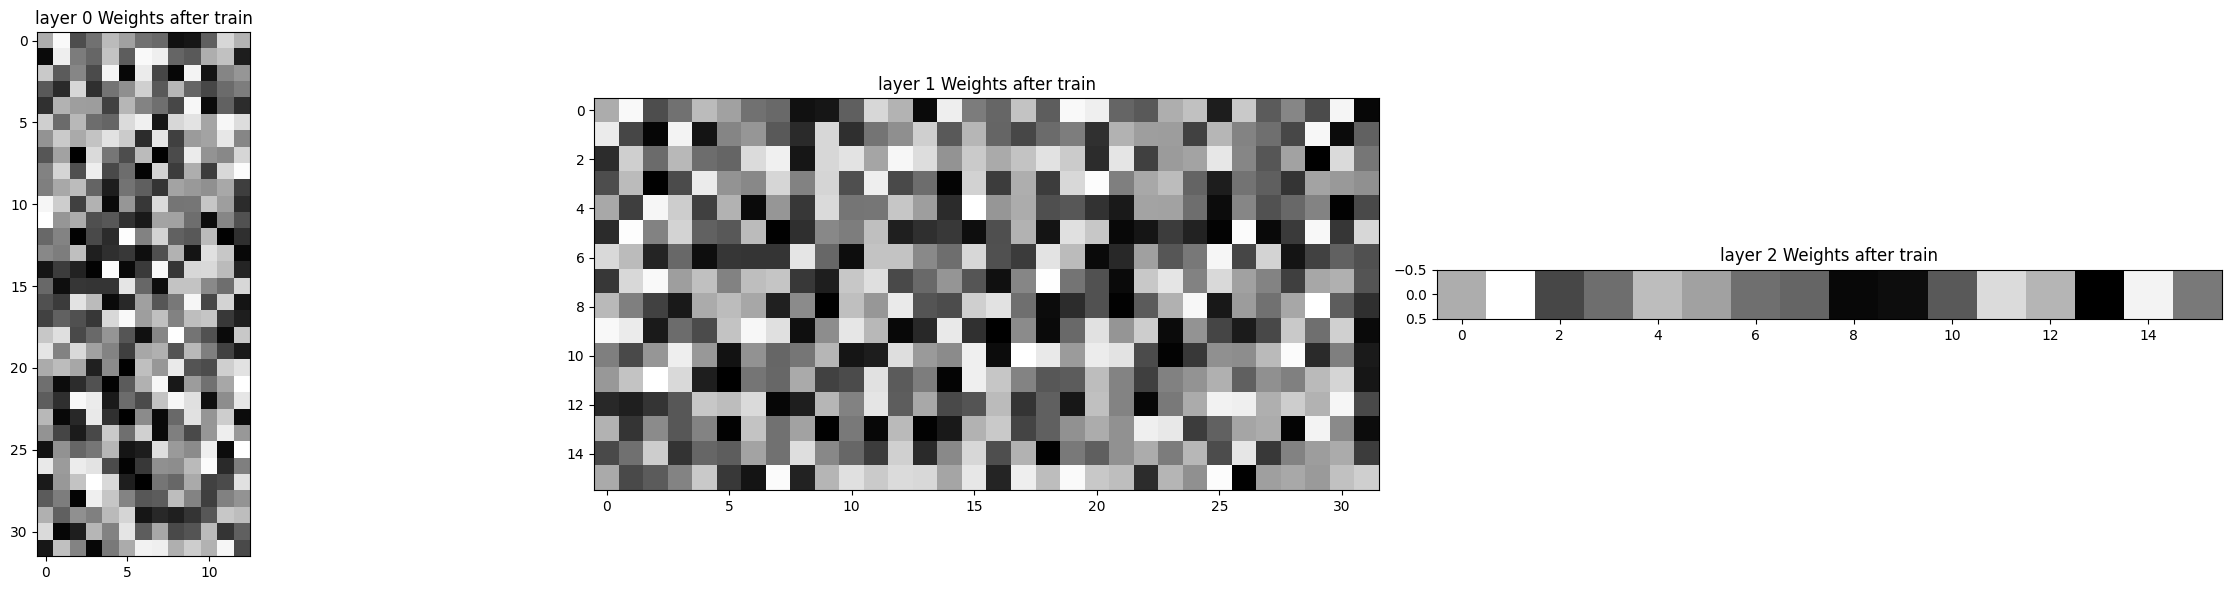

In [24]:

fix,ax = plt.subplots(1,3,figsize=(25,6))
for i,axes in enumerate(ax):
    w = Weights_n_B[i][0]
    axes.imshow(w,cmap='gray')
    axes.set_title(f'layer {i} Weights after train')

plt.tight_layout()
plt.show()

# Checking the performace on test set

In [25]:
print('Mean squared error on test set after training is {:.2f}'.format(MeanSquaredError(X_test,Y_test,Weights_n_B)))

Mean squared error on test set after training is 605.85


**Parallelizing the training**

In [26]:
parallel_train_step = pmap(train_step,
                           in_axes=(0,0,None) # which input axes do we want to parallelize
                          )
def shard_data(X,y=None,batch_size=batch_size,num_replicas=num_replicas):
    '''converts the input data in the format (num_of_devices,batch_size,feature_size)'''
    features = X.shape[1]

    if y is not None:
        return X.reshape((num_replicas,batch_size,features)),y.reshape((num_replicas,batch_size,1))


    return X.reshape((num_replicas,batch_size,features))


#sharded data (to get the input in format: num_of_devices,batch_size,feature_size)
x_sharded,y_sharded = shard_data(X_train,Y_train)


x_sharded.shape,y_sharded.shape

((2, 202, 13), (2, 202, 1))